In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Feb 9 2025

@author: Yaning
"""

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.nn.functional as F # mainly for ReLU
import numpy as np
import copy
import re
from tqdm import tqdm
from transformers import BatchEncoding

/home/yaning/Documents/python_env/llm/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2Model

tokenizer = AutoTokenizer.from_pretrained("dbmdz/german-gpt2")
model = GPT2Model.from_pretrained("dbmdz/german-gpt2")
model.eval()

GPT2Model(
  (wte): Embedding(50265, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.0, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [ ]:
# with open('/home/yaning/Documents/LLM/skip_gram/hochdeutsch.txt', 'r') as file:
#     h_text = file.read()

# with open('/home/yaning/Documents/LLM/skip_gram/sachsen.txt', 'r') as file:
#     s_text = file.read()

In [3]:
with open('/home/yaning/Documents/LLM/skip_gram/h_book.txt', 'r') as file:
    h_text = file.read()

with open('/home/yaning/Documents/LLM/skip_gram/s_book.txt', 'r') as file:
    s_text = file.read()

In [4]:
processed_s_text = s_text.lower()
processed_s_text = re.sub(r'[.,]', " ", processed_s_text)
processed_s_text = re.sub(r'\s+', " ", processed_s_text)

processed_h_text = h_text.lower()
processed_h_text = re.sub(r'[.,]', " ", processed_h_text)
processed_h_text = re.sub(r'\s+', " ", processed_h_text)

processed_h_text = re.sub(r'[^a-zA-ZäöüÄÖÜß\s]+', '', processed_h_text)
processed_s_text = re.sub(r'[^a-zA-ZäöüÄÖÜß\s]+', '', processed_s_text)

In [5]:
tokenizer(processed_h_text)

{'input_ids': [487, 31339, 440, 404, 3895, 2008, 73, 2699, 540, 3730, 2765, 4329, 292, 6472, 1210, 375, 30951, 292, 1881, 462, 633, 22961, 45672, 2765, 4329, 11311, 1080, 296, 17946, 6871, 485, 24231, 355, 8382, 32224, 495, 385, 946, 33134, 1435, 485, 2588, 784, 43696, 286, 1090, 416, 24376, 292, 374, 444, 4220, 987, 371, 375, 404, 2876, 495, 1253, 709, 568, 412, 35383, 10625, 535, 709, 30440, 1292, 1753, 286, 301, 3462, 2089, 8556, 4384, 1435, 2014, 671, 286, 2765, 4329, 1267, 2571, 4066, 1753, 827, 355, 374, 298, 1447, 271, 2817, 335, 3204, 468, 355, 3497, 1000, 5522, 1025, 4540, 430, 467, 613, 2008, 73, 12445, 298, 45191, 374, 469, 21232, 9556, 690, 225, 296, 4564, 1514, 292, 339, 321, 384, 3869, 8094, 264, 344, 11647, 709, 1263, 2765, 4329, 17929, 339, 1891, 8556, 292, 5829, 11628, 355, 2765, 4329, 1171, 374, 2668, 8847, 355, 37032, 418, 15052, 296, 11841, 292, 286, 276, 1578, 6463, 18490, 292, 1789, 709, 2062, 2294, 464, 17392, 1778, 7958, 1049, 292, 1300, 540, 6169, 495, 374, 355

In [5]:
# tokenise the sentences
tokens_h = tokenizer(processed_h_text)['input_ids']
tokens_s = tokenizer(processed_s_text)['input_ids']

In [6]:
len(tokens_h)

1867

In [7]:
len(tokens_s)

1990

In [8]:
train_h = []
# batch the tokens with ratio
ratio = len(tokens_s)/len(tokens_h)
# every 10 tokens of hochdeutsch is a batch
batch_size = 10
for i in range(len(tokens_h)-batch_size+1):
    temp = tokens_h[i:i+batch_size]
    temp.append(1)
    # temp.append(1)
    train_h.append(temp)

In [54]:
tokenizer.decode(1)

'<pad>'

In [62]:
ratio*10

12.30381569474442

In [9]:
import random
train_s = []
for i in range(len(train_h)):
    batch_size_s = round(batch_size*ratio)
    center = (batch_size*0.5+0.5+i)*ratio
    chunk_begin = round(center - batch_size_s/2)
    chunk_end = round(center + batch_size_s/2)
    if chunk_end - chunk_begin != batch_size_s:
        random_number = random.randint(0, 1)
        if random_number == 0:
            chunk_begin = chunk_begin+1
        else:
            chunk_end = chunk_end-1
    
    if chunk_begin < 0:
        chunk_begin = 0
    if chunk_end > len(tokens_s)-1:
        chunk_end = len(tokens_s)-1
    
    temp = tokens_s[chunk_begin:chunk_end]
    while len(temp) < batch_size_s:
        temp.append(1)
    train_s.append(temp)

In [10]:
# Define the Transition Layer (T)
class TransitionLayer(nn.Module):
    def __init__(self, embedding_dim):
        super(TransitionLayer, self).__init__()
        # Trainable transition matrix to map standard to dialect
        self.transition_matrix = nn.Parameter(torch.randn(embedding_dim, embedding_dim))
    
    def forward(self, standard_embeddings):
        # Apply the transformation: H_dialect = T * H_standard
        return torch.matmul(standard_embeddings, self.transition_matrix)

In [11]:
embedding_dim = model.config.hidden_size #768 dimensions
transition_layer = TransitionLayer(embedding_dim).to("cuda")

In [75]:
len(train_s)

2769

In [12]:
model.to("cuda")

GPT2Model(
  (wte): Embedding(50265, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.0, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [13]:
# Define Mean Squared Error loss
criterion = nn.MSELoss()

# Optimizer (e.g., Adam)
optimizer = optim.Adam(transition_layer.parameters(), lr=0.0001)
losses = []

# Training loop
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    for batch in range(len(train_h)):
        # get train_h and train_s in token form with input_ids and mask
        temp_h = BatchEncoding({
            'input_ids': torch.tensor(train_h[batch]),
            'attention_mask': torch.tensor([1]*len(train_h[batch]))
        }).to("cuda")
        temp_s = BatchEncoding({
            'input_ids': torch.tensor(train_s[batch]),
            'attention_mask': torch.tensor([1]*len(train_s[batch]))
        }).to("cuda")
        # print(type(temp_h))
        # Get standard language embeddings
        with torch.no_grad():
            standard_outputs = model(**temp_h)
            # standard_outputs = model.base_model(**standard_inputs, output_hidden_states=True)
            # standard_hidden_states = standard_outputs.hidden_states[-1]  # Last hidden state (batch_size, seq_len, hidden_size)
            standard_hidden_states = standard_outputs.last_hidden_state

        # Get dialect embeddings (ground truth)
        with torch.no_grad():
            dialect_outputs = model(**temp_s)
            dialect_hidden_states = dialect_outputs.last_hidden_state
        
        # Apply the transition matrix to map standard to dialect space
        predicted_dialect_hidden_states = transition_layer(standard_hidden_states)
        # predicted_dialect_hidden_states = transition_layer(dialect_hidden_states)
        
        # loss = criterion(predicted_dialect_hidden_states, standard_hidden_states)
        loss = criterion(predicted_dialect_hidden_states, dialect_hidden_states)
        losses.append(loss)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


  0%|                                                                                       | 0/10 [00:00<?, ?it/s]

 20%|███████████████▊                                                               | 2/10 [00:33<02:15, 16.96s/it]

Epoch [2/10], Loss: 359.0662


 40%|███████████████████████████████▌                                               | 4/10 [01:07<01:41, 16.91s/it]

Epoch [4/10], Loss: 280.2552


 60%|███████████████████████████████████████████████▍                               | 6/10 [01:41<01:07, 16.89s/it]

Epoch [6/10], Loss: 121.8604


 80%|███████████████████████████████████████████████████████████████▏               | 8/10 [02:15<00:33, 16.89s/it]

Epoch [8/10], Loss: 74.6332


100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [02:48<00:00, 16.89s/it]

Epoch [10/10], Loss: 62.3183


In [14]:
relocate = []
for i in losses:
    relocate.append(i.cpu().detach().numpy())

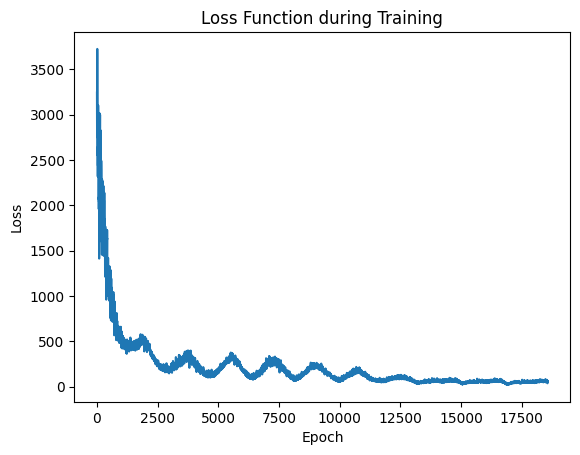

In [15]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(relocate) + 1), relocate, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Function during Training')
# plt.legend()
# plt.savefig("loss_trans.png", dpi=300)
plt.show()

In [16]:
torch.save(transition_layer.state_dict(), 'transition_matrix_new.pth')

In [16]:
transition_layer.transition_matrix

Parameter containing:
tensor([[-0.5910,  0.1576,  0.2107,  ..., -0.5723, -0.1585,  0.0602],
        [ 0.7323, -0.1410, -0.1167,  ...,  0.3420, -0.0147,  0.5277],
        [ 0.2163,  0.4753,  0.3169,  ..., -0.3228, -0.0765,  0.0823],
        ...,
        [-0.1993,  0.0079,  0.2882,  ..., -0.2099, -0.1832,  0.3412],
        [-0.6584,  0.1000, -0.2687,  ..., -0.0026,  0.5316, -0.1420],
        [ 0.0918,  1.0976, -0.5679,  ...,  0.0862, -0.5491, -0.3439]],
       device='cuda:0', requires_grad=True)